/tmp/ipykernel_77779/4242548148.py:30: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(likelihoods[top_k_indices]))
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_77779/4242548148.py:30: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(likelihoods[top_k_indices]))


Overlap in top-1000 points: 0/1000 (0.00%)
Full likelihood parameters (mu1, mu2, sigma, mix): -1.426859293326671 1.6516056313269543 1.0852575671553968 0.5017150228202805
Top-K likelihood parameters (mu1, mu2, sigma, mix): -2.053025237251824 1.3648715452030036 0.06448339658595094 0.6150000049546234


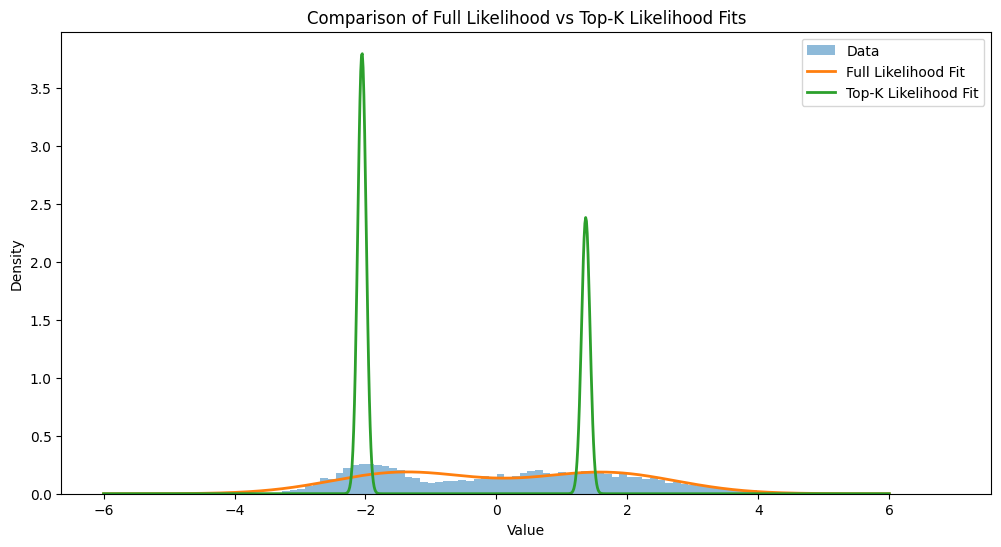

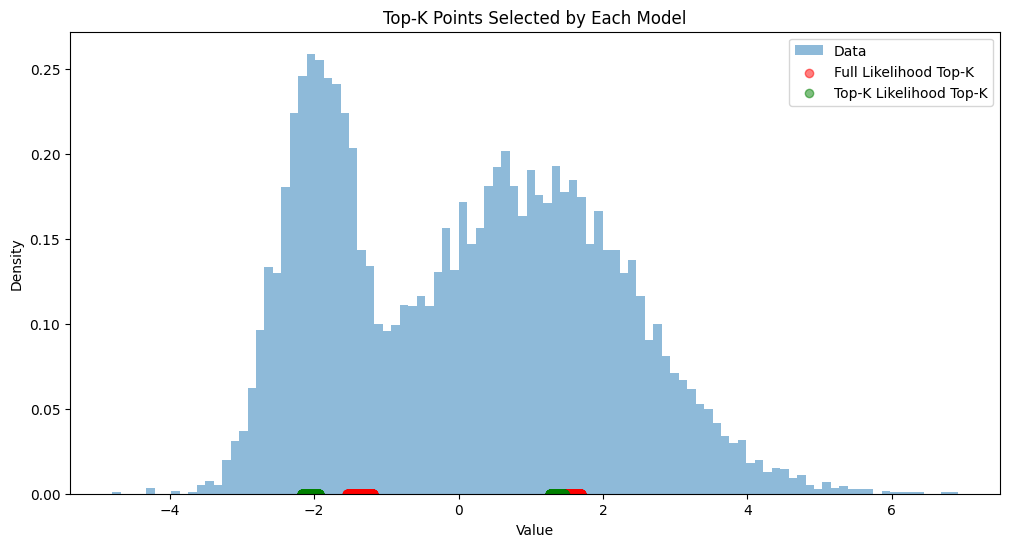

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

# Generate synthetic dataset
def generate_dataset(n_samples=10000):
    samples1 = np.random.normal(-2, 0.5, size=int(0.3 * n_samples))
    samples2 = np.random.normal(1, 1.5, size=int(0.7 * n_samples))
    return np.concatenate([samples1, samples2])

# Define model (mixture of two Gaussians with shared variance)
def model_pdf(x, mu1, mu2, shared_sigma, mix):
    return mix * norm.pdf(x, mu1, shared_sigma) + (1 - mix) * norm.pdf(x, mu2, shared_sigma)

# Log-likelihood function
def log_likelihood(params, data):
    mu1, mu2, log_sigma, logit_mix = params
    shared_sigma = np.exp(log_sigma)
    mix = 1 / (1 + np.exp(-logit_mix))
    return np.sum(np.log(model_pdf(data, mu1, mu2, shared_sigma, mix)))

# Top-K log-likelihood function
def top_k_log_likelihood(params, data, k):
    mu1, mu2, log_sigma, logit_mix = params
    shared_sigma = np.exp(log_sigma)
    mix = 1 / (1 + np.exp(-logit_mix))
    likelihoods = model_pdf(data, mu1, mu2, shared_sigma, mix)
    top_k_indices = np.argsort(likelihoods)[-k:]
    return np.sum(np.log(likelihoods[top_k_indices]))

# Optimization function for full likelihood
def optimize_likelihood(data, initial_guess):
    def neg_log_likelihood(params):
        return -log_likelihood(params, data)
    
    result = minimize(neg_log_likelihood, initial_guess, method='BFGS', options={'maxiter': 100000})
    return result.x

# Optimization function for top-K likelihood
def optimize_top_k(data, initial_guess, k):
    def neg_top_k_log_likelihood(params):
        return -top_k_log_likelihood(params, data, k)
    
    result = minimize(neg_top_k_log_likelihood, initial_guess, method='BFGS', options={'maxiter': 100000})
    return result.x

# Generate data
data = generate_dataset()

# Initial guess for parameters (mu1, mu2, log_sigma, logit_mix)
initial_guess = [-2, 1, 0, 0]

# Optimize for full likelihood and top-K likelihood
full_params = optimize_likelihood(data, initial_guess)
k = int(0.1 * len(data))  # Top 10% of data
top_k_params = optimize_top_k(data, initial_guess, k)

# Function to get top-k points
def get_top_k_points(data, params, k):
    mu1, mu2, log_sigma, logit_mix = params
    shared_sigma = np.exp(log_sigma)
    mix = 1 / (1 + np.exp(-logit_mix))
    likelihoods = model_pdf(data, mu1, mu2, shared_sigma, mix)
    return np.argsort(likelihoods)[-k:]

# Get top-k points for both models
full_top_k = get_top_k_points(data, full_params, k)
topk_top_k = get_top_k_points(data, top_k_params, k)

# Calculate overlap
overlap = len(set(full_top_k) & set(topk_top_k))
print(f"Overlap in top-{k} points: {overlap}/{k} ({overlap/k*100:.2f}%)")

# Print results
print("Full likelihood parameters (mu1, mu2, sigma, mix):", 
      full_params[0], full_params[1], np.exp(full_params[2]), 1/(1+np.exp(-full_params[3])))
print("Top-K likelihood parameters (mu1, mu2, sigma, mix):", 
      top_k_params[0], top_k_params[1], np.exp(top_k_params[2]), 1/(1+np.exp(-top_k_params[3])))

# Plotting
x = np.linspace(-6, 6, 1000)
plt.figure(figsize=(12, 6))

plt.hist(data, bins=100, density=True, alpha=0.5, label='Data')
plt.plot(x, model_pdf(x, *full_params[:2], np.exp(full_params[2]), 1/(1+np.exp(-full_params[3]))), 
         label='Full Likelihood Fit', linewidth=2)
plt.plot(x, model_pdf(x, *top_k_params[:2], np.exp(top_k_params[2]), 1/(1+np.exp(-top_k_params[3]))), 
         label='Top-K Likelihood Fit', linewidth=2)

plt.legend()
plt.title("Comparison of Full Likelihood vs Top-K Likelihood Fits")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

# Plotting top-k points
plt.figure(figsize=(12, 6))
plt.hist(data, bins=100, density=True, alpha=0.5, label='Data')
plt.scatter(data[full_top_k], np.zeros_like(data[full_top_k]), color='red', label='Full Likelihood Top-K', alpha=0.5)
plt.scatter(data[topk_top_k], np.zeros_like(data[topk_top_k]), color='green', label='Top-K Likelihood Top-K', alpha=0.5)
plt.legend()
plt.title("Top-K Points Selected by Each Model")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [12]:
k

1000

In [5]:
disagree = [topk_top_k[i] for i in range(k) if topk_top_k[i] not in full_top_k]

In [6]:
len(disagree)

1000

In [15]:
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from torch_models import torch_bpr_uncurried, deterministic_bpr

Full likelihood parameters: [ 1.          1.         -1.9337499   0.82104938  1.          1.
 -1.9337499   0.82104938  0.5       ]
Top-K likelihood parameters: [ 0.89678176  0.63028156 -2.47225324 -2.38946424  0.89678176  0.63028156
 -2.47225324 -2.38946424  0.5       ]


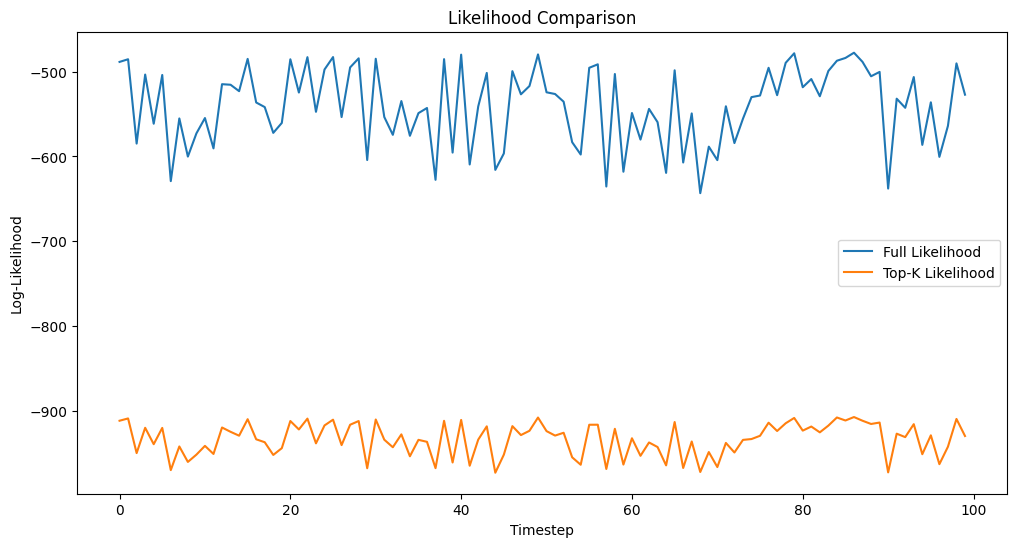

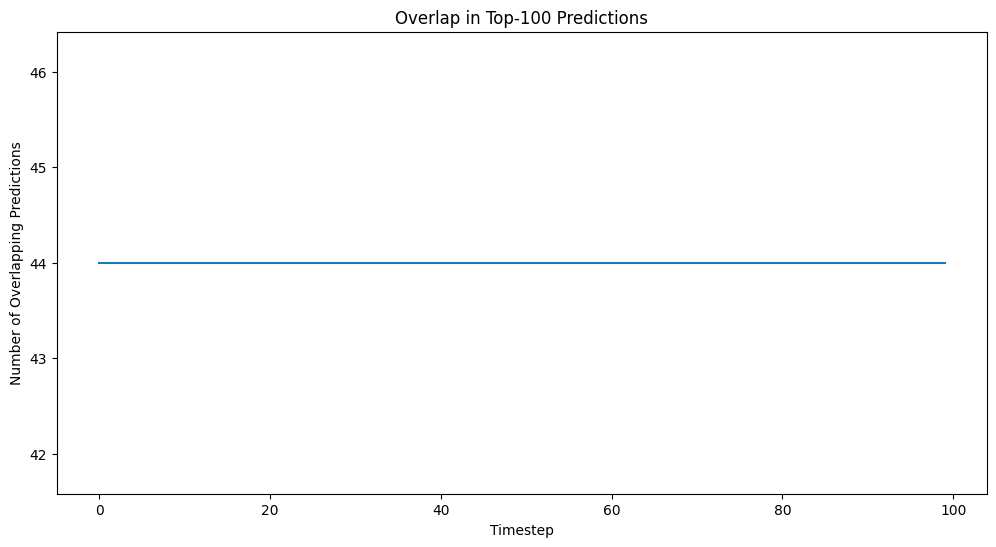

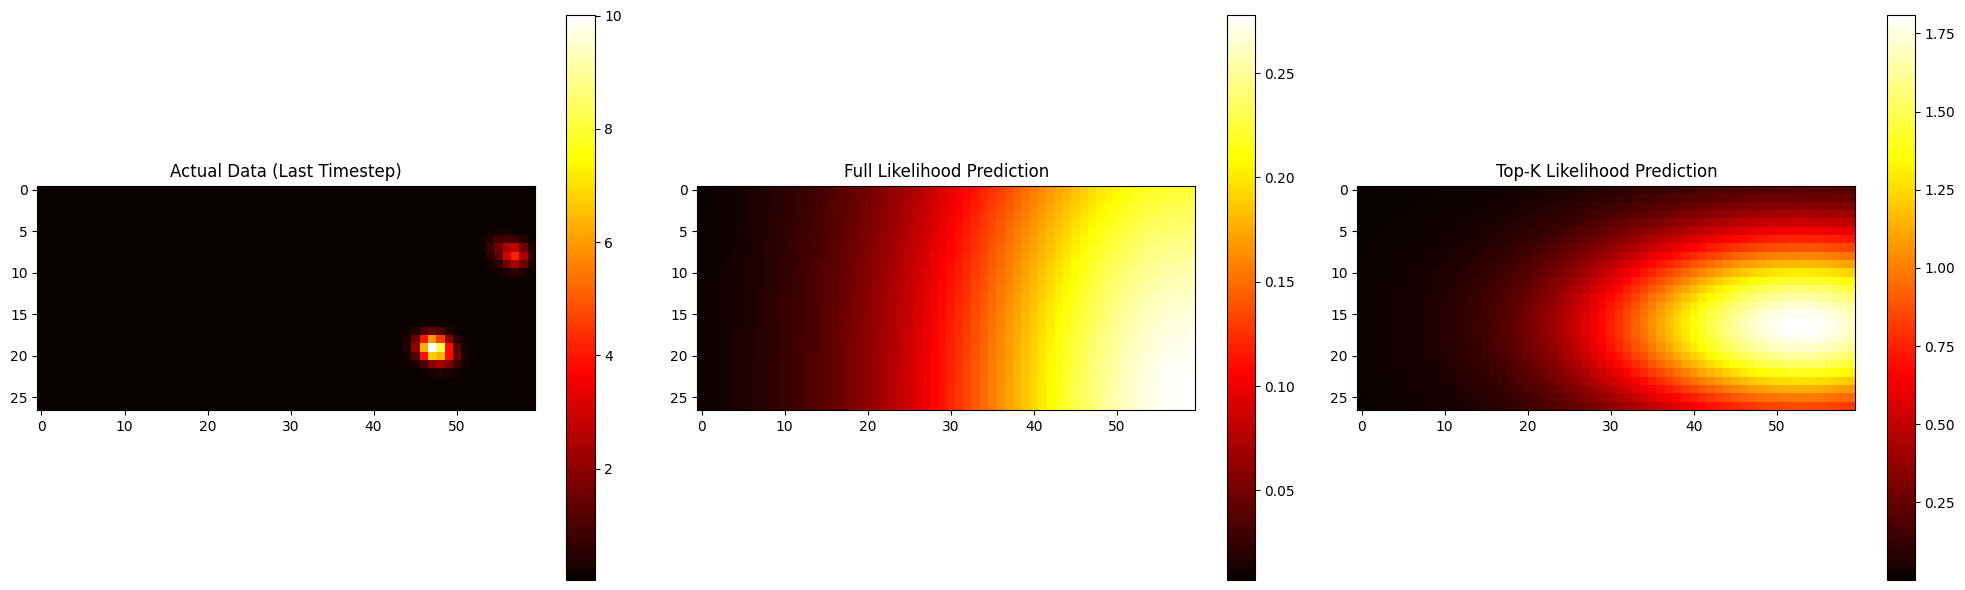

Data range:  0.026568289413872168 10.0


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize


# Generate synthetic spatial-temporal dataset
def generate_dataset(grid_shape=(27, 60), n_timesteps=100):
    data = np.zeros((n_timesteps, grid_shape[0] * grid_shape[1]))
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    positions = np.dstack((x, y))

    # Create two persistent Gaussian distributions
    mean1, mean2 = np.random.rand(2, 2)
    cov1, cov2 = np.random.rand(2, 2, 2) * 0.02
    cov1, cov2 = cov1.dot(cov1.T), cov2.dot(cov2.T)  # Ensure positive semi-definite

    for t in range(n_timesteps):
        # Large, diffuse Gaussian
        amplitude1 = np.random.uniform(2, 4)
        gaussian1 = amplitude1 * multivariate_normal.pdf(positions, mean=mean1, cov=cov1)
        
        # Small, more intense Gaussian
        amplitude2 = np.random.uniform(3, 5)
        gaussian2 = amplitude2 * multivariate_normal.pdf(positions, mean=mean2, cov=cov2)
        
        grid_data = gaussian1 + gaussian2
        
        # Add smooth noise
        noise = gaussian_filter(np.random.normal(2, 0.2, grid_shape), sigma=1)
        grid_data += noise
        
        # Apply spatial smoothing
        grid_data = gaussian_filter(grid_data, sigma=1)
        
        # Ensure non-negativity and scale
        grid_data = np.maximum(grid_data, 0)
        grid_data = grid_data / np.max(grid_data) * 10  # Scale to 0-10 range
        
        data[t] = grid_data.flatten()
    
    return data

# Define model (mixture of two Gaussians)
def model_predict(params, grid_shape):
    mu1_x, mu1_y, log_sigma1_x, log_sigma1_y, mu2_x, mu2_y, log_sigma2_x, log_sigma2_y, mix = params
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    pos = np.dstack((x, y))
    
    cov1 = np.diag([np.exp(log_sigma1_x), np.exp(log_sigma1_y)])
    cov2 = np.diag([np.exp(log_sigma2_x), np.exp(log_sigma2_y)])
    
    rv1 = multivariate_normal([mu1_x, mu1_y], cov1)
    rv2 = multivariate_normal([mu2_x, mu2_y], cov2)
    
    prediction = mix * rv1.pdf(pos) + (1 - mix) * rv2.pdf(pos)
    return prediction.flatten()

# Log-likelihood function
def log_likelihood(params, data, grid_shape):
    total_ll = 0
    for t in range(data.shape[0]):
        prediction = model_predict(params, grid_shape)
        total_ll += np.sum(data[t] * np.log(prediction + 1e-10) - prediction)  # Poisson log-likelihood
    return total_ll

# Top-K log-likelihood function
def top_k_log_likelihood(params, data, grid_shape, k):
    total_ll = 0
    for t in range(data.shape[0]):
        prediction = model_predict(params, grid_shape)
        top_k_indices = np.argsort(data[t])[-k:]
        total_ll += np.sum(data[t][top_k_indices] * np.log(prediction[top_k_indices] + 1e-10) - prediction[top_k_indices])
    return total_ll

# Optimization function for full likelihood
def optimize_likelihood(data, grid_shape, initial_guess):
    def neg_log_likelihood(params):
        return -log_likelihood(params, data, grid_shape)
    
    bounds = [(0,1), (0,1), (-5,2), (-5,2)] * 2 + [(0,1)]
    result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Optimization function for top-K likelihood
def optimize_top_k(data, grid_shape, initial_guess, k):
    def neg_top_k_log_likelihood(params):
        return -top_k_log_likelihood(params, data, grid_shape, k)
    
    bounds = [(0,1), (0,1), (-5,2), (-5,2)] * 2 + [(0,1)]
    result = minimize(neg_top_k_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Function to calculate likelihood for all timesteps
def calculate_likelihood(params, data, grid_shape):
    likelihoods = []
    for t in range(data.shape[0]):
        prediction = model_predict(params, grid_shape)
        ll = np.sum(data[t] * np.log(prediction + 1e-10) - prediction)  # Poisson log-likelihood
        likelihoods.append(ll)
    return np.array(likelihoods)

# Function to calculate top-K likelihood for all timesteps
def calculate_top_k_likelihood(params, data, grid_shape, k):
    likelihoods = []
    for t in range(data.shape[0]):
        prediction = model_predict(params, grid_shape)
        top_k_indices = np.argsort(data[t])[-k:]
        ll = np.sum(data[t][top_k_indices] * np.log(prediction[top_k_indices] + 1e-10) - prediction[top_k_indices])
        likelihoods.append(ll)
    return np.array(likelihoods)

# Function to get top-k predictions
def get_top_k_predictions(params, data, grid_shape, k):
    predictions = []
    for t in range(data.shape[0]):
        prediction = model_predict(params, grid_shape)
        top_k = set(np.argsort(prediction)[-k:])
        predictions.append(top_k)
    return predictions

# Main execution
if __name__ == "__main__":
    # Generate data
    grid_shape = (27, 60)
    data = generate_dataset(grid_shape)

    # Initial parameters (mu1_x, mu1_y, log_sigma1_x, log_sigma1_y, mu2_x, mu2_y, log_sigma2_x, log_sigma2_y, mix)
    initial_guess = [0.5, 0.5, 0, 0, 0.5, 0.5, 0, 0, 0.5]

    # Optimize for full likelihood and top-K likelihood
    full_params = optimize_likelihood(data, grid_shape, initial_guess)
    top_k_params = optimize_top_k(data, grid_shape, initial_guess, k=100)

    print("Full likelihood parameters:", full_params)
    print("Top-K likelihood parameters:", top_k_params)

    # Calculate likelihoods
    full_likelihoods = calculate_likelihood(full_params, data, grid_shape)
    top_k_likelihoods = calculate_likelihood(top_k_params, data, grid_shape)#calculate_top_k_likelihood(top_k_params, data, grid_shape, k=100)

    # Plot likelihoods
    plt.figure(figsize=(12, 6))
    plt.plot(range(data.shape[0]), full_likelihoods, label='Full Likelihood')
    plt.plot(range(data.shape[0]), top_k_likelihoods, label='Top-K Likelihood')
    plt.title("Likelihood Comparison")
    plt.xlabel("Timestep")
    plt.ylabel("Log-Likelihood")
    plt.legend()
    plt.show()

    # Get top-k predictions for both models
    full_top_k = get_top_k_predictions(full_params, data, grid_shape, 100)
    topk_top_k = get_top_k_predictions(top_k_params, data, grid_shape, 100)

    # Calculate overlap
    overlaps = [len(full_set & topk_set) for full_set, topk_set in zip(full_top_k, topk_top_k)]

    # Plot overlap
    plt.figure(figsize=(12, 6))
    plt.plot(range(data.shape[0]), overlaps)
    plt.title("Overlap in Top-100 Predictions")
    plt.xlabel("Timestep")
    plt.ylabel("Number of Overlapping Predictions")
    plt.show()

    # Visualize the last timestep predictions
    last_full_prediction = model_predict(full_params, grid_shape)
    last_top_k_prediction = model_predict(top_k_params, grid_shape)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    im0 = ax1.imshow(data[-1].reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax1.set_title("Actual Data (Last Timestep)")
    plt.colorbar(im0, ax=ax1)

    im1 = ax2.imshow(last_full_prediction.reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax2.set_title("Full Likelihood Prediction")
    plt.colorbar(im1, ax=ax2)

    im2 = ax3.imshow(last_top_k_prediction.reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax3.set_title("Top-K Likelihood Prediction")
    plt.colorbar(im2, ax=ax3)

    plt.tight_layout()
    plt.show()

    # Print the range of values in the dataset
    print("Data range: ", np.min(data), np.max(data))

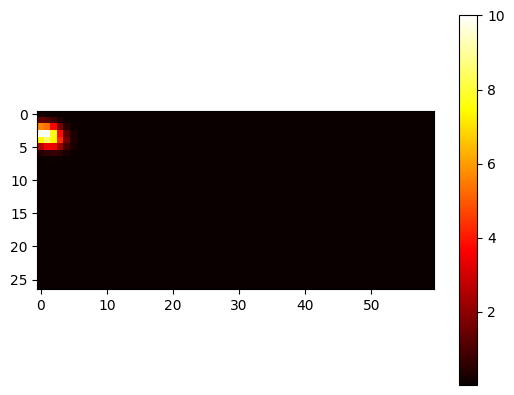

In [46]:
plt.imshow(data[95].reshape(grid_shape), cmap='hot', interpolation='nearest')
plt.colorbar()

In [9]:
data[-1].shape

(1620,)

In [54]:
deterministic_bpr(torch.tensor(last_top_k_prediction).unsqueeze(0), torch.tensor(data[-1]).unsqueeze(0),100)

tensor([0.4006], dtype=torch.float64)

In [55]:
deterministic_bpr(torch.tensor(last_full_prediction).unsqueeze(0), torch.tensor(data[-1]).unsqueeze(0),100)

tensor([0.0310], dtype=torch.float64)

In [30]:
data[0,:10]

array([0.00034209, 0.00011144, 0.        , 0.00013292, 0.00033536,
       0.00043991, 0.00040981, 0.00027328, 0.00011142, 0.        ])

Full likelihood parameters: [ 1.14474129e-03  0.00000000e+00  9.11918964e-01  9.99288544e-01
 -9.53169502e-01 -9.41998185e-01  7.92688970e-01  7.92935145e-01
 -5.00000000e+00 -5.00000000e+00 -5.84072916e-01 -5.84678238e-01
  9.07377019e-01]
Top-K likelihood parameters: [ 0.09842917  0.48999994 -2.17920538 -1.62223142  0.59381939  1.
  0.80697687  0.80068233 -5.         -5.         -0.61158842 -0.604178
  0.84269177]


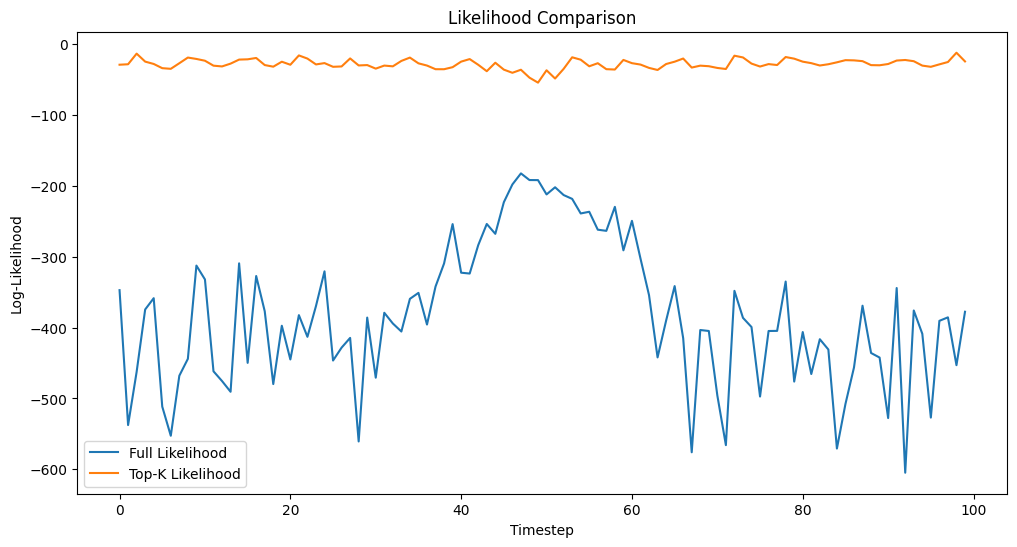

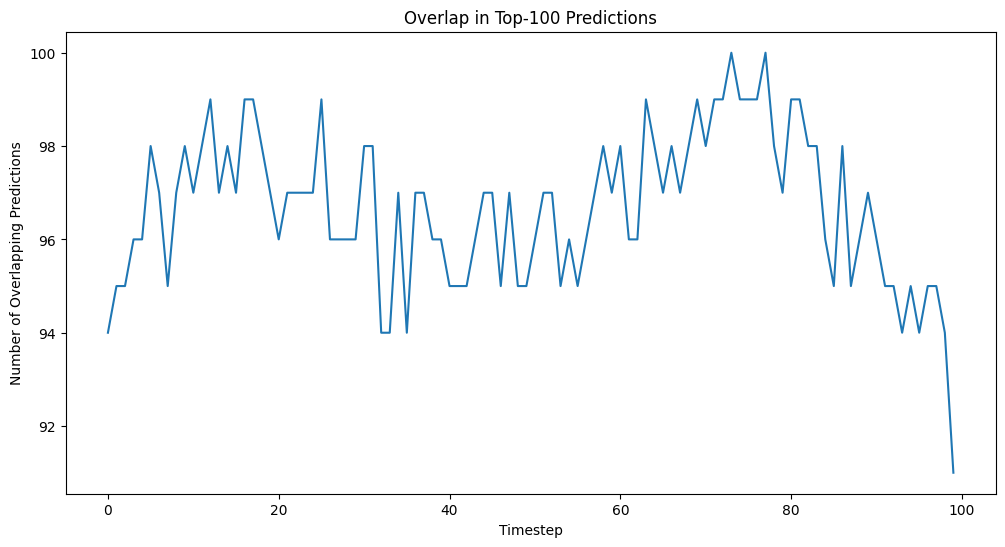

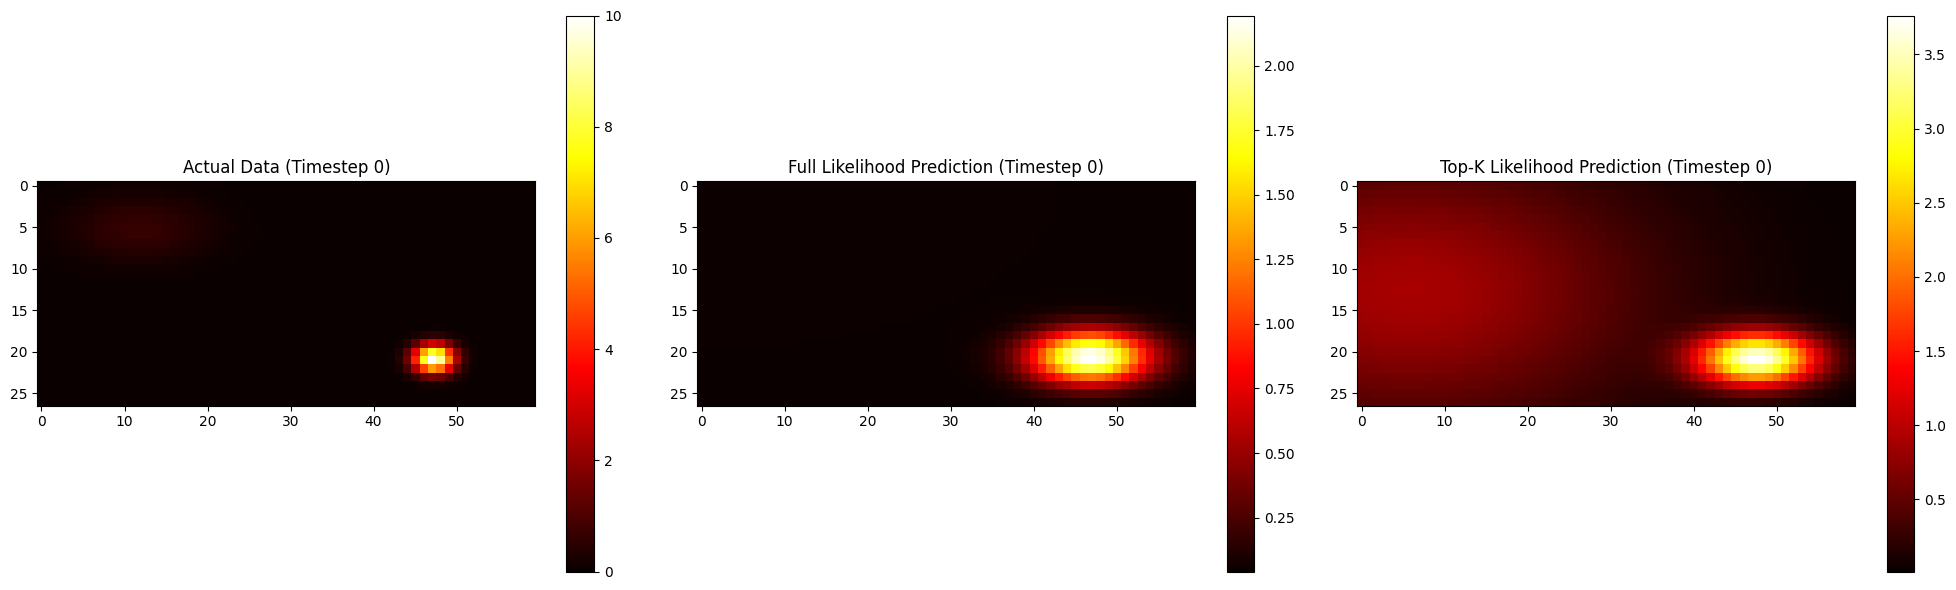

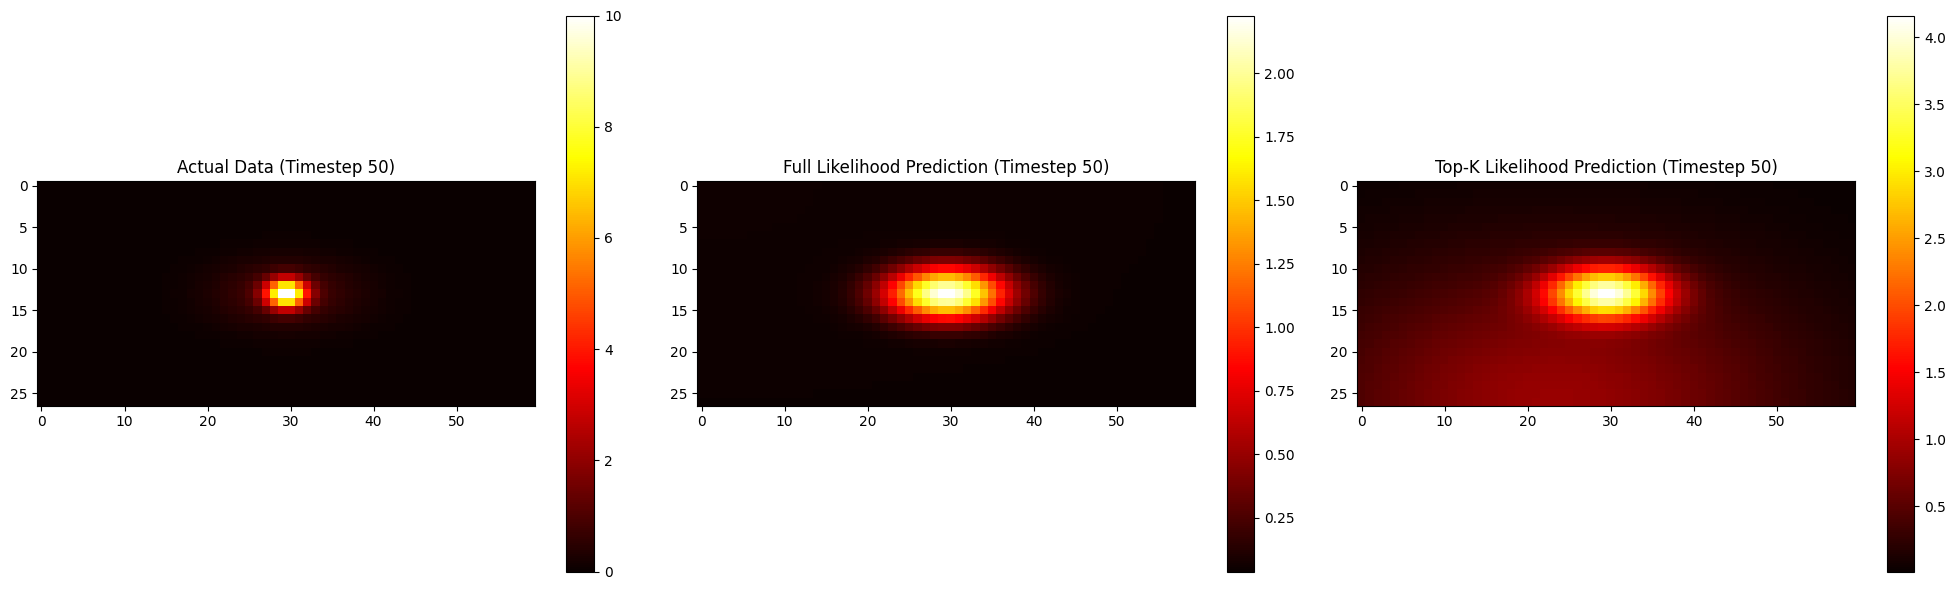

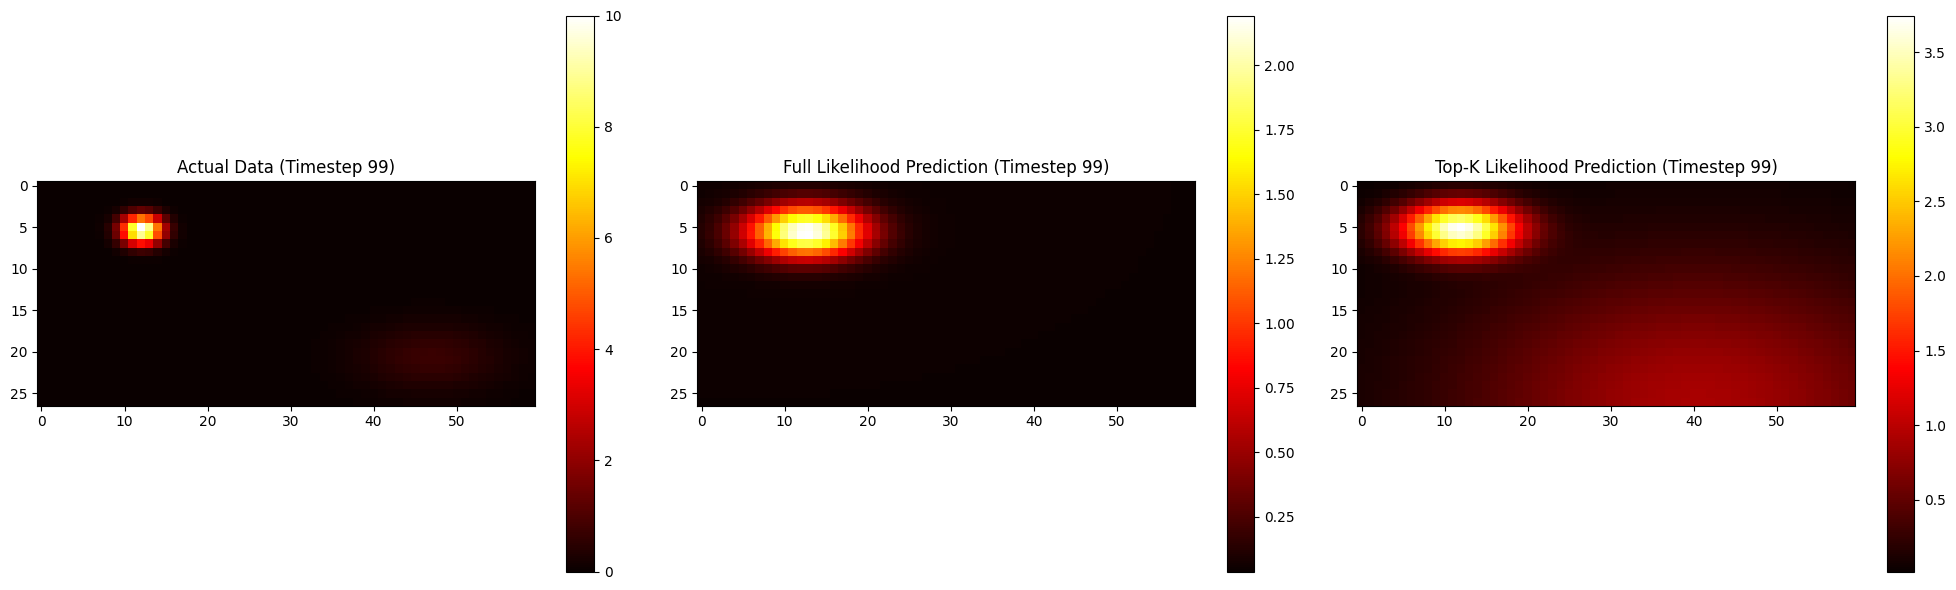

Data range:  0.0 10.0


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

# Generate synthetic spatial-temporal dataset with moving high-value regions
def generate_dataset(grid_shape=(27, 60), n_timesteps=100):
    data = np.zeros((n_timesteps, grid_shape[0] * grid_shape[1]))
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    positions = np.dstack((x, y))

    # Create two moving Gaussian distributions
    mean1 = np.array([0.2, 0.2])
    mean2 = np.array([0.8, 0.8])
    velocity1 = np.array([0.6, 0.6]) / n_timesteps
    velocity2 = np.array([-0.6, -0.6]) / n_timesteps
    cov1, cov2 = np.eye(2) * 0.01, np.eye(2) * 0.0005

    for t in range(n_timesteps):
        # Update positions
        current_mean1 = mean1 + t * velocity1
        current_mean2 = mean2 + t * velocity2

        # Ensure means stay within the grid
        current_mean1 = np.clip(current_mean1, 0, 1)
        current_mean2 = np.clip(current_mean2, 0, 1)

        # Large, diffuse Gaussian
        amplitude1 = np.random.uniform(2, 4)
        gaussian1 = amplitude1 * multivariate_normal.pdf(positions, mean=current_mean1, cov=cov1)
        
        # Small, more intense Gaussian
        amplitude2 = np.random.uniform(3, 5)
        gaussian2 = amplitude2 * multivariate_normal.pdf(positions, mean=current_mean2, cov=cov2)
        
        grid_data = gaussian1 + gaussian2
        
        # Add smooth noise
        noise = gaussian_filter(np.random.normal(0, 0.2, grid_shape), sigma=1)
        grid_data += noise
        
        # Apply spatial smoothing
        grid_data = gaussian_filter(grid_data, sigma=1)
        
        # Ensure non-negativity and scale
        grid_data = np.maximum(grid_data, 0)
        grid_data = grid_data / np.max(grid_data) * 10  # Scale to 0-10 range
        
        data[t] = grid_data.flatten()
    
    return data

# Define model (mixture of two Gaussians with time-dependent means)
def model_predict(params, grid_shape, t, n_timesteps):
    mu1_x, mu1_y, log_sigma1_x, log_sigma1_y, v1_x, v1_y, mu2_x, mu2_y, log_sigma2_x, log_sigma2_y, v2_x, v2_y, mix = params
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    pos = np.dstack((x, y))
    
    # Time-dependent means
    current_mu1 = np.array([mu1_x, mu1_y]) + np.array([v1_x, v1_y]) * t / n_timesteps
    current_mu2 = np.array([mu2_x, mu2_y]) + np.array([v2_x, v2_y]) * t / n_timesteps

    # Ensure means stay within the grid
    current_mu1 = np.clip(current_mu1, 0, 1)
    current_mu2 = np.clip(current_mu2, 0, 1)
    
    cov1 = np.diag([np.exp(log_sigma1_x), np.exp(log_sigma1_y)])
    cov2 = np.diag([np.exp(log_sigma2_x), np.exp(log_sigma2_y)])
    
    rv1 = multivariate_normal(current_mu1, cov1)
    rv2 = multivariate_normal(current_mu2, cov2)
    
    prediction = mix * rv1.pdf(pos) + (1 - mix) * rv2.pdf(pos)
    return prediction.flatten()

# Log-likelihood function
def log_likelihood(params, data, grid_shape):
    total_ll = 0
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        total_ll += np.sum(data[t] * np.log(prediction + 1e-10) - prediction)  # Poisson log-likelihood
    return total_ll

# Top-K log-likelihood function
def top_k_log_likelihood(params, data, grid_shape, k):
    total_ll = 0
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        top_k_indices = np.argsort(data[t])[-k:]
        total_ll += np.sum(data[t][top_k_indices] * np.log(prediction[top_k_indices] + 1e-10) - prediction[top_k_indices])
    return total_ll

# Optimization function for full likelihood
def optimize_likelihood(data, grid_shape, initial_guess):
    def neg_log_likelihood(params):
        return -log_likelihood(params, data, grid_shape)
    
    bounds = [(0,1), (0,1), (-5,2), (-5,2), (-1,1), (-1,1)] * 2 + [(0,1)]
    result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Optimization function for top-K likelihood
def optimize_top_k(data, grid_shape, initial_guess, k):
    def neg_top_k_log_likelihood(params):
        return -top_k_log_likelihood(params, data, grid_shape, k)
    
    bounds = [(0,1), (0,1), (-5,2), (-5,2), (-1,1), (-1,1)] * 2 + [(0,1)]
    result = minimize(neg_top_k_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Function to calculate likelihood for all timesteps
def calculate_likelihood(params, data, grid_shape):
    likelihoods = []
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        ll = np.sum(data[t] * np.log(prediction + 1e-10) - prediction)  # Poisson log-likelihood
        likelihoods.append(ll)
    return np.array(likelihoods)

# Function to calculate top-K likelihood for all timesteps
def calculate_top_k_likelihood(params, data, grid_shape, k):
    likelihoods = []
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        top_k_indices = np.argsort(data[t])[-k:]
        ll = np.sum(data[t][top_k_indices] * np.log(prediction[top_k_indices] + 1e-10) - prediction[top_k_indices])
        likelihoods.append(ll)
    return np.array(likelihoods)

# Function to get top-k predictions
def get_top_k_predictions(params, data, grid_shape, k):
    predictions = []
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        top_k = set(np.argsort(prediction)[-k:])
        predictions.append(top_k)
    return predictions

# Main execution
if __name__ == "__main__":
    # Generate data
    grid_shape = (27, 60)
    n_timesteps = 100
    data = generate_dataset(grid_shape, n_timesteps)

    # Initial parameters (mu1_x, mu1_y, log_sigma1_x, log_sigma1_y, v1_x, v1_y, mu2_x, mu2_y, log_sigma2_x, log_sigma2_y, v2_x, v2_y, mix)
    initial_guess = [0.2, 0.2, 0, 0, 0.5, 0.5, 0.8, 0.8, 0, 0, -0.5, -0.5, 0.5]

    # Optimize for full likelihood and top-K likelihood
    full_params = optimize_likelihood(data, grid_shape, initial_guess)
    top_k_params = optimize_top_k(data, grid_shape, initial_guess, k=100)

    print("Full likelihood parameters:", full_params)
    print("Top-K likelihood parameters:", top_k_params)

    # Calculate likelihoods
    full_likelihoods = calculate_likelihood(full_params, data, grid_shape)
    top_k_likelihoods = calculate_top_k_likelihood(top_k_params, data, grid_shape, k=100)

    # Plot likelihoods
    plt.figure(figsize=(12, 6))
    plt.plot(range(n_timesteps), full_likelihoods, label='Full Likelihood')
    plt.plot(range(n_timesteps), top_k_likelihoods, label='Top-K Likelihood')
    plt.title("Likelihood Comparison")
    plt.xlabel("Timestep")
    plt.ylabel("Log-Likelihood")
    plt.legend()
    plt.show()

    # Get top-k predictions for both models
    full_top_k = get_top_k_predictions(full_params, data, grid_shape, 100)
    topk_top_k = get_top_k_predictions(top_k_params, data, grid_shape, 100)

    # Calculate overlap
    overlaps = [len(full_set & topk_set) for full_set, topk_set in zip(full_top_k, topk_top_k)]

    # Plot overlap
    plt.figure(figsize=(12, 6))
    plt.plot(range(n_timesteps), overlaps)
    plt.title("Overlap in Top-100 Predictions")
    plt.xlabel("Timestep")
    plt.ylabel("Number of Overlapping Predictions")
    plt.show()

    # Visualize the first, middle, and last timestep predictions
    timesteps_to_plot = [0, n_timesteps // 2, n_timesteps - 1]
    
    for plot_t in timesteps_to_plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        im0 = ax1.imshow(data[plot_t].reshape(grid_shape), cmap='hot', interpolation='nearest')
        ax1.set_title(f"Actual Data (Timestep {plot_t})")
        plt.colorbar(im0, ax=ax1)

        im1 = ax2.imshow(model_predict(full_params, grid_shape, plot_t, n_timesteps).reshape(grid_shape), cmap='hot', interpolation='nearest')
        ax2.set_title(f"Full Likelihood Prediction (Timestep {plot_t})")
        plt.colorbar(im1, ax=ax2)

        im2 = ax3.imshow(model_predict(top_k_params, grid_shape, plot_t, n_timesteps).reshape(grid_shape), cmap='hot', interpolation='nearest')
        ax3.set_title(f"Top-K Likelihood Prediction (Timestep {plot_t})")
        plt.colorbar(im2, ax=ax3)

        plt.tight_layout()
        plt.show()

    # Print the range of values in the dataset
    print("Data range: ", np.min(data), np.max(data))

In [98]:
deterministic_bpr(torch.tensor(model_predict(top_k_params, grid_shape, 99, 100)).unsqueeze(0), torch.tensor(data[99]).unsqueeze(0),100)

TypeError: model_predict() takes 2 positional arguments but 4 were given

In [99]:
deterministic_bpr(torch.tensor([model_predict(top_k_params, grid_shape, t, 100) for t in range(100)]), torch.tensor(data),100).mean()

TypeError: model_predict() takes 2 positional arguments but 4 were given

In [100]:
deterministic_bpr(torch.tensor([model_predict(full_params, grid_shape, t, 100) for t in range(100)]), torch.tensor(data),100).mean()

TypeError: model_predict() takes 2 positional arguments but 4 were given

Full likelihood parameters: [ 0.07318662  0.07589187  1.          1.         -0.65152848 -0.65041342
 -1.         -1.          0.13606703  0.        ]
Top-K likelihood parameters: [ 0.          0.39583314  0.80436653  0.7983688   0.95927597  1.
 -0.60111296 -0.59742196 -2.33709302  0.81435118]
Full likelihood of full model: -51963.49771111361
Full likelihood of top-k model: -118941.75589468796


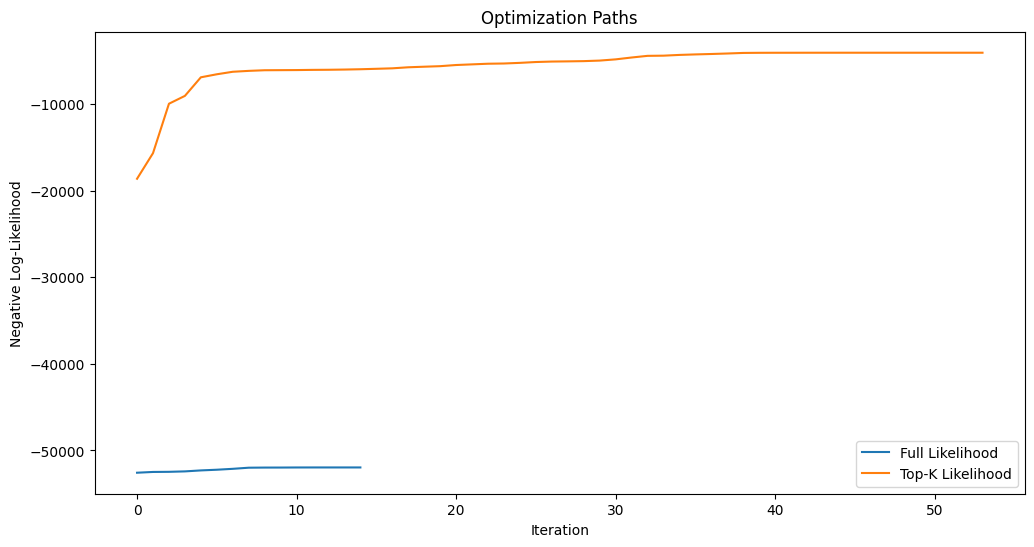

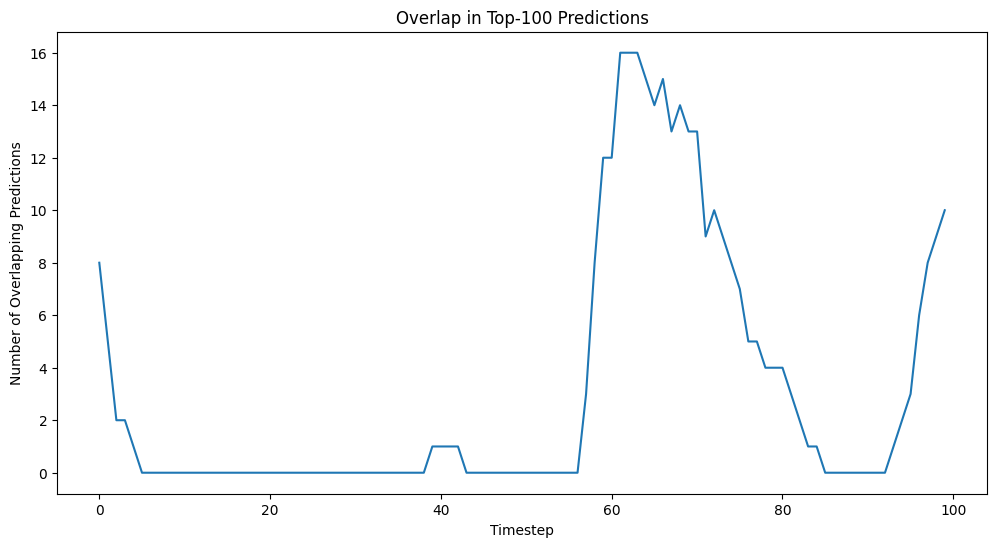

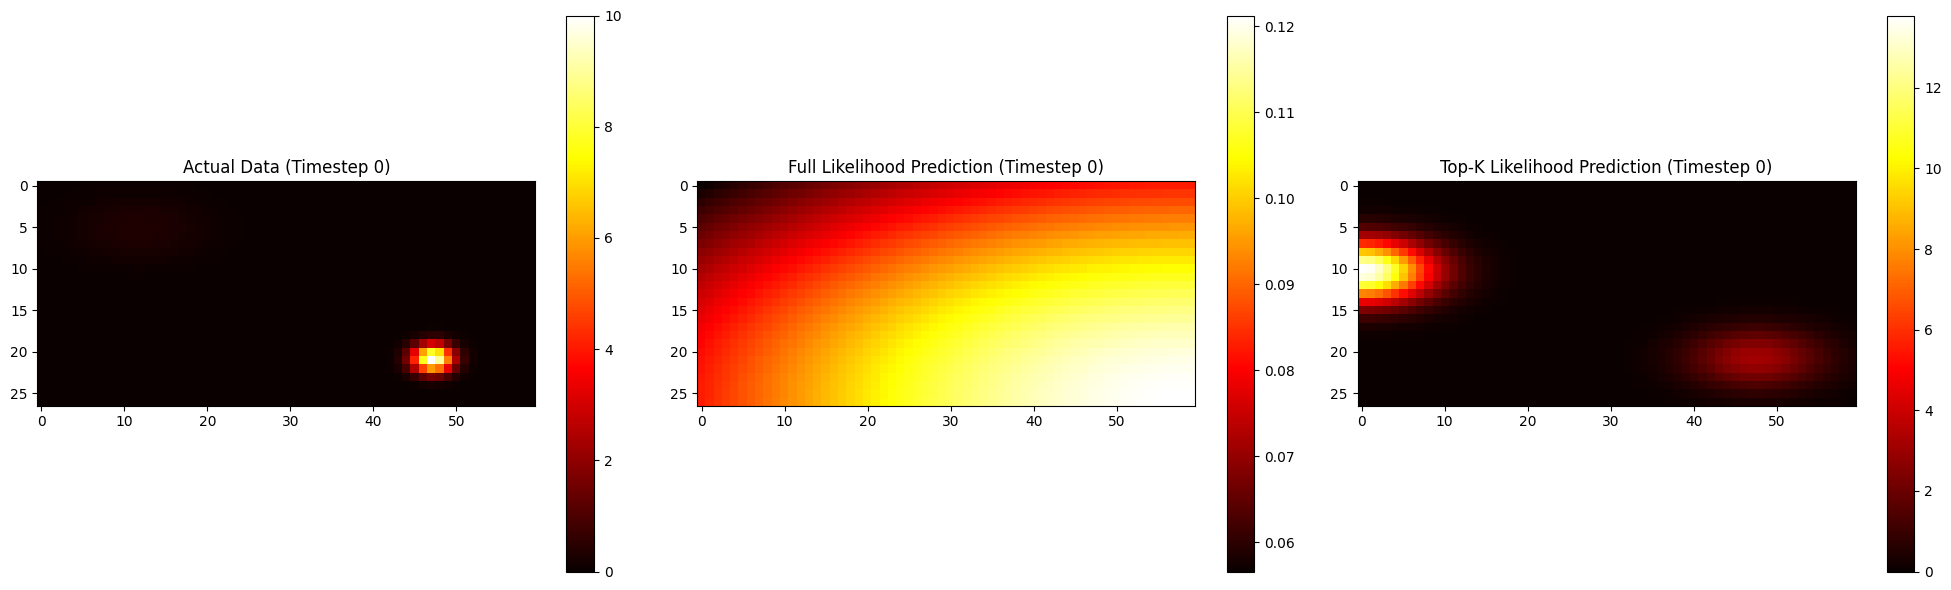

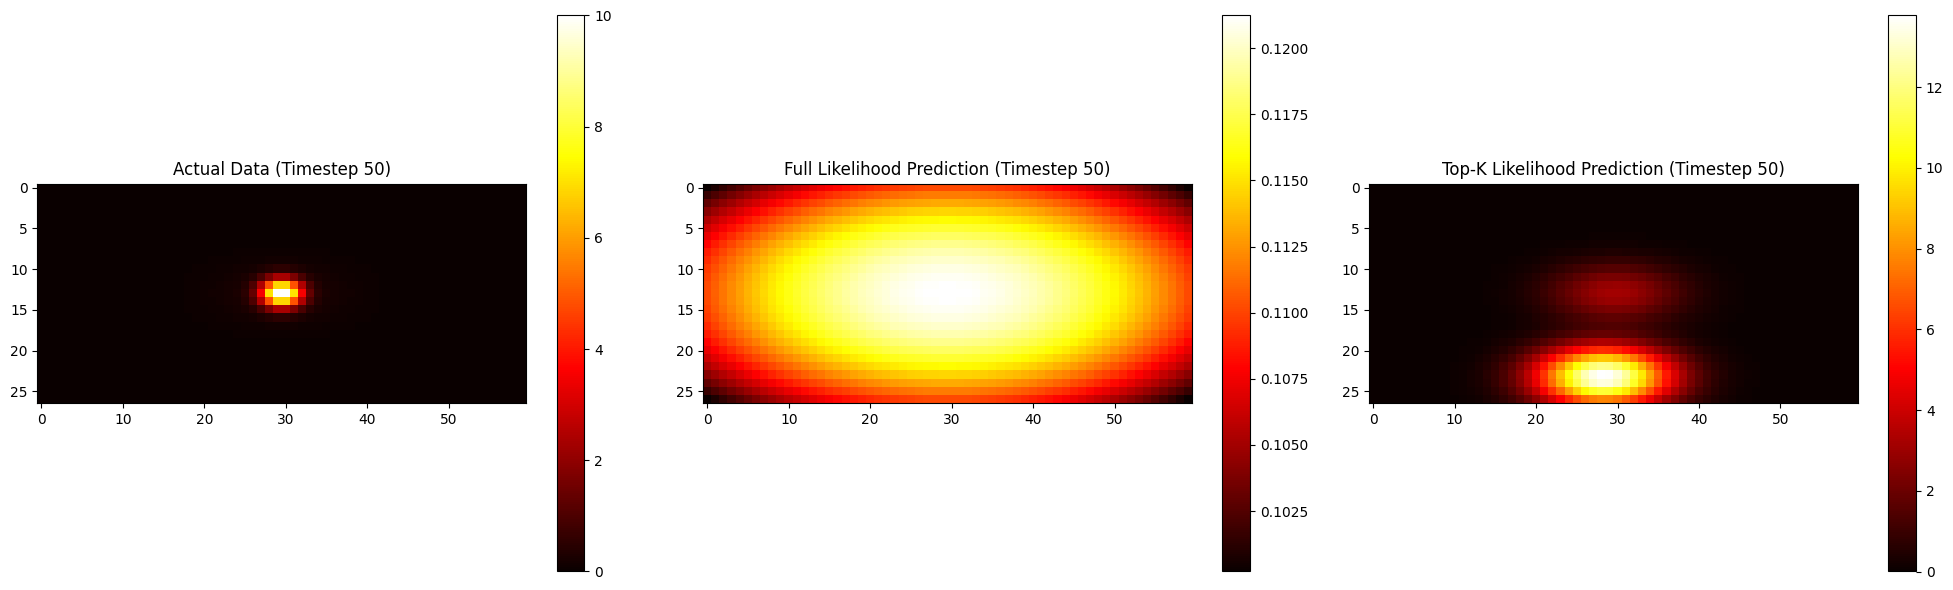

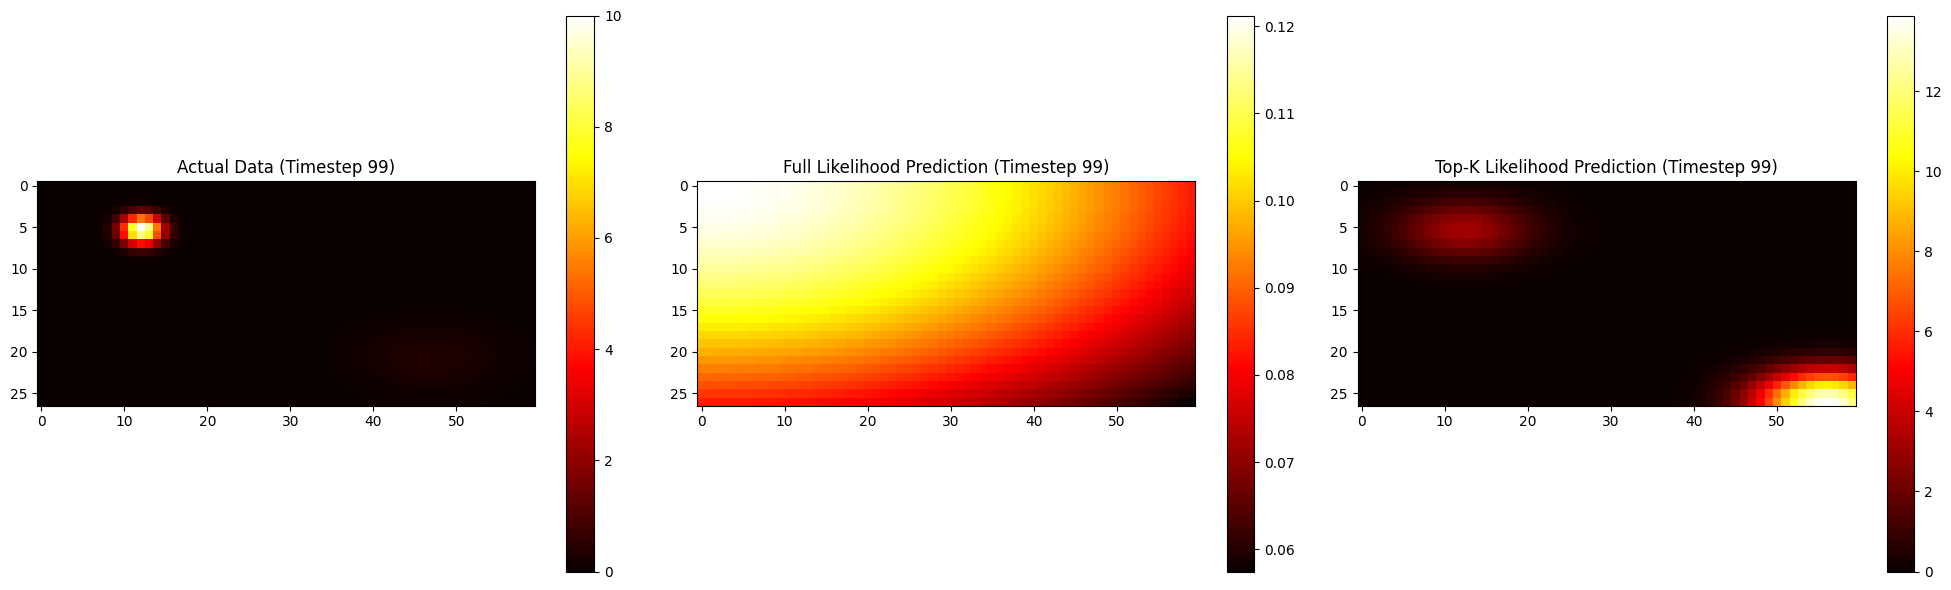

Data range:  0.0 10.0


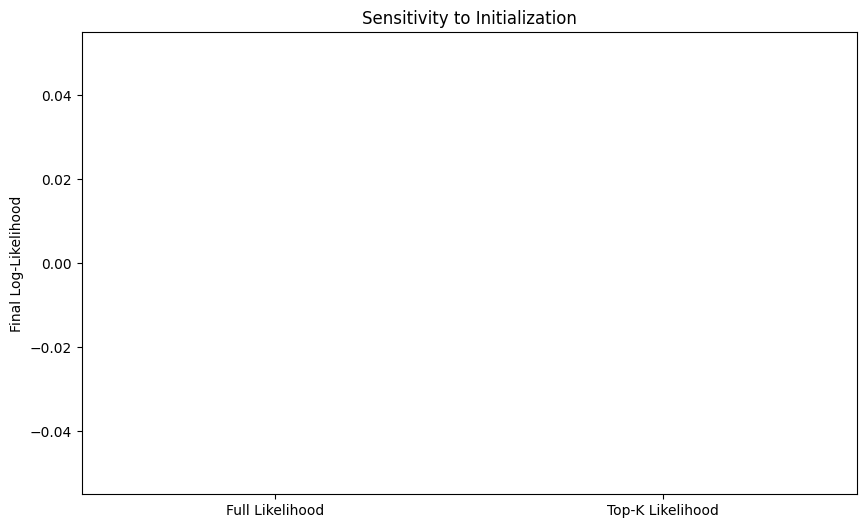

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

# Generate synthetic spatial-temporal dataset with moving high-value regions
def generate_dataset(grid_shape=(27, 60), n_timesteps=100):
    data = np.zeros((n_timesteps, grid_shape[0] * grid_shape[1]))
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    positions = np.dstack((x, y))

    # Create two moving Gaussian distributions
    mean1 = np.array([0.2, 0.2])
    mean2 = np.array([0.8, 0.8])
    velocity1 = np.array([0.6, 0.6]) / n_timesteps
    velocity2 = np.array([-0.6, -0.6]) / n_timesteps
    cov1, cov2 = np.eye(2) * 0.01, np.eye(2) * 0.0005

    for t in range(n_timesteps):
        # Update positions
        current_mean1 = mean1 + t * velocity1
        current_mean2 = mean2 + t * velocity2

        # Ensure means stay within the grid
        current_mean1 = np.clip(current_mean1, 0, 1)
        current_mean2 = np.clip(current_mean2, 0, 1)

        # Large, diffuse Gaussian
        amplitude1 = np.random.uniform(2, 3)
        gaussian1 = amplitude1 * multivariate_normal.pdf(positions, mean=current_mean1, cov=cov1)
        
        # Small, more intense Gaussian
        amplitude2 = np.random.uniform(8, 10)
        gaussian2 = amplitude2 * multivariate_normal.pdf(positions, mean=current_mean2, cov=cov2)
        
        grid_data = gaussian1 + gaussian2
        
        # Add smooth noise
        noise = gaussian_filter(np.random.normal(0, 0.2, grid_shape), sigma=1)
        grid_data += noise
        
        # Apply spatial smoothing
        grid_data = gaussian_filter(grid_data, sigma=1)
        
        # Ensure non-negativity and scale
        grid_data = np.maximum(grid_data, 0)
        grid_data = grid_data / np.max(grid_data) * 10  # Scale to 0-10 range
        
        data[t] = grid_data.flatten()
    
    return data

# Define model (mixture of two Gaussians with time-dependent means and shared scale)
def model_predict(params, grid_shape, t, n_timesteps):
    mu1_x, mu1_y, mu2_x, mu2_y, v1_x, v1_y, v2_x, v2_y, log_shared_sigma, mix = params
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    pos = np.dstack((x, y))
    
    # Time-dependent means
    current_mu1 = np.array([mu1_x, mu1_y]) + np.array([v1_x, v1_y]) * t / n_timesteps
    current_mu2 = np.array([mu2_x, mu2_y]) + np.array([v2_x, v2_y]) * t / n_timesteps

    # Ensure means stay within the grid
    current_mu1 = np.clip(current_mu1, 0, 1)
    current_mu2 = np.clip(current_mu2, 0, 1)
    
    shared_sigma = np.exp(log_shared_sigma)
    cov = np.eye(2) * shared_sigma**2
    
    rv1 = multivariate_normal(current_mu1, cov)
    rv2 = multivariate_normal(current_mu2, cov)
    
    prediction = mix * rv1.pdf(pos) + (1 - mix) * rv2.pdf(pos)
    return prediction.flatten()

# Log-likelihood function
def log_likelihood(params, data, grid_shape):
    total_ll = 0
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        total_ll += np.sum(data[t] * np.log(prediction + 1e-10) - prediction)  # Poisson log-likelihood
    return total_ll

# Top-K log-likelihood function
def top_k_log_likelihood(params, data, grid_shape, k):
    total_ll = 0
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        top_k_indices = np.argsort(data[t])[-k:]
        total_ll += np.sum(data[t][top_k_indices] * np.log(prediction[top_k_indices] + 1e-10) - prediction[top_k_indices])
    return total_ll

# Updated optimization function with callback
def optimize_likelihood(data, grid_shape, initial_guess, method='full', k=100):
    def neg_log_likelihood(params):
        if method == 'full':
            return -log_likelihood(params, data, grid_shape)
        elif method == 'top-k':
            return -top_k_log_likelihood(params, data, grid_shape, k)
    
    bounds = [(0,1), (0,1), (0,1), (0,1), (-1,1), (-1,1), (-1,1), (-1,1), (-5,2), (0,1)]
    
    optimization_path = []
    def callback(xk):
        optimization_path.append((xk, neg_log_likelihood(xk)))
    
    result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds, callback=callback)
    return result.x, optimization_path
# Optimization function for top-K likelihood
def optimize_top_k(data, grid_shape, initial_guess, k):
    def neg_top_k_log_likelihood(params):
        return -top_k_log_likelihood(params, data, grid_shape, k)
    
    bounds = [(0,1), (0,1), (0,1), (0,1), (-1,1), (-1,1), (-1,1), (-1,1), (-5,2), (0,1)]
    result = minimize(neg_top_k_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Function to calculate likelihood for all timesteps
def calculate_likelihood(params, data, grid_shape):
    likelihoods = []
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        ll = np.sum(data[t] * np.log(prediction + 1e-10) - prediction)  # Poisson log-likelihood
        likelihoods.append(ll)
    return np.array(likelihoods)

# Function to calculate top-K likelihood for all timesteps
def calculate_top_k_likelihood(params, data, grid_shape, k):
    likelihoods = []
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        top_k_indices = np.argsort(data[t])[-k:]
        ll = np.sum(data[t][top_k_indices] * np.log(prediction[top_k_indices] + 1e-10) - prediction[top_k_indices])
        likelihoods.append(ll)
    return np.array(likelihoods)

# Function to get top-k predictions
def get_top_k_predictions(params, data, grid_shape, k):
    predictions = []
    n_timesteps = data.shape[0]
    for t in range(n_timesteps):
        prediction = model_predict(params, grid_shape, t, n_timesteps)
        top_k = set(np.argsort(prediction)[-k:])
        predictions.append(top_k)
    return predictions

# Main execution
if __name__ == "__main__":
    # Generate data
    grid_shape = (27, 60)
    n_timesteps = 100
    data = generate_dataset(grid_shape, n_timesteps)

    # Initial parameters (mu1_x, mu1_y, mu2_x, mu2_y, v1_x, v1_y, v2_x, v2_y, log_shared_sigma, mix)
    initial_guess = [0.2, 0.2, 0.8, 0.8, 0.5, 0.5, -0.5, -0.5, 0, 0.5]

        # Optimize for full likelihood and top-K likelihood
    full_params, full_path = optimize_likelihood(data, grid_shape, initial_guess, method='full')
    top_k_params, top_k_path = optimize_likelihood(data, grid_shape, initial_guess, method='top-k', k=100)

    print("Full likelihood parameters:", full_params)
    print("Top-K likelihood parameters:", top_k_params)

    # Calculate full likelihood for both models
    full_ll = log_likelihood(full_params, data, grid_shape)
    top_k_full_ll = log_likelihood(top_k_params, data, grid_shape)

    print(f"Full likelihood of full model: {full_ll}")
    print(f"Full likelihood of top-k model: {top_k_full_ll}")

    # Plot optimization paths
    plt.figure(figsize=(12, 6))
    plt.plot([i for i in range(len(full_path))], [-ll for _, ll in full_path], label='Full Likelihood')
    plt.plot([i for i in range(len(top_k_path))], [-ll for _, ll in top_k_path], label='Top-K Likelihood')
    plt.title("Optimization Paths")
    plt.xlabel("Iteration")
    plt.ylabel("Negative Log-Likelihood")
    plt.legend()
    plt.show()

    # Get top-k predictions for both models
    full_top_k = get_top_k_predictions(full_params, data, grid_shape, 100)
    topk_top_k = get_top_k_predictions(top_k_params, data, grid_shape, 100)

    # Calculate overlap
    overlaps = [len(full_set & topk_set) for full_set, topk_set in zip(full_top_k, topk_top_k)]

    # Plot overlap
    plt.figure(figsize=(12, 6))
    plt.plot(range(n_timesteps), overlaps)
    plt.title("Overlap in Top-100 Predictions")
    plt.xlabel("Timestep")
    plt.ylabel("Number of Overlapping Predictions")
    plt.show()

    # Visualize the first, middle, and last timestep predictions
    timesteps_to_plot = [0, n_timesteps // 2, n_timesteps - 1]
    
    for plot_t in timesteps_to_plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        im0 = ax1.imshow(data[plot_t].reshape(grid_shape), cmap='hot', interpolation='nearest')
        ax1.set_title(f"Actual Data (Timestep {plot_t})")
        plt.colorbar(im0, ax=ax1)

        im1 = ax2.imshow(model_predict(full_params, grid_shape, plot_t, n_timesteps).reshape(grid_shape), cmap='hot', interpolation='nearest')
        ax2.set_title(f"Full Likelihood Prediction (Timestep {plot_t})")
        plt.colorbar(im1, ax=ax2)

        im2 = ax3.imshow(model_predict(top_k_params, grid_shape, plot_t, n_timesteps).reshape(grid_shape), cmap='hot', interpolation='nearest')
        ax3.set_title(f"Top-K Likelihood Prediction (Timestep {plot_t})")
        plt.colorbar(im2, ax=ax3)

        plt.tight_layout()
        plt.show()

    # Print the range of values in the dataset
    print("Data range: ", np.min(data), np.max(data))

    
    # Sensitivity analysis
    n_trials = 0
    full_results = []
    top_k_results = []

    for _ in range(n_trials):
        random_init = np.random.rand(10)
        full_params, _ = optimize_likelihood(data, grid_shape, random_init, method='full')
        top_k_params, _ = optimize_likelihood(data, grid_shape, random_init, method='top-k', k=100)
        
        full_results.append(log_likelihood(full_params, data, grid_shape))
        top_k_results.append(log_likelihood(top_k_params, data, grid_shape))

    plt.figure(figsize=(10, 6))
    plt.boxplot([full_results, top_k_results], labels=['Full Likelihood', 'Top-K Likelihood'])
    plt.title("Sensitivity to Initialization")
    plt.ylabel("Final Log-Likelihood")
    plt.show()

Full likelihood parameters: [-9.16921751  0.56874486  0.70579862  1.83368951 -2.52273855  0.30363657
  0.06043213  1.35666853 -3.88972837  0.07703989  0.18325459  1.98412551
 -3.59845601]
Top-K likelihood parameters: [ 2.          0.74926663  0.57863957  1.13874611 -4.11895034  0.43292133
  0.96005419  0.89127614 -1.91312021  0.15331571  0.12611842  1.17829511
 -2.79617136]


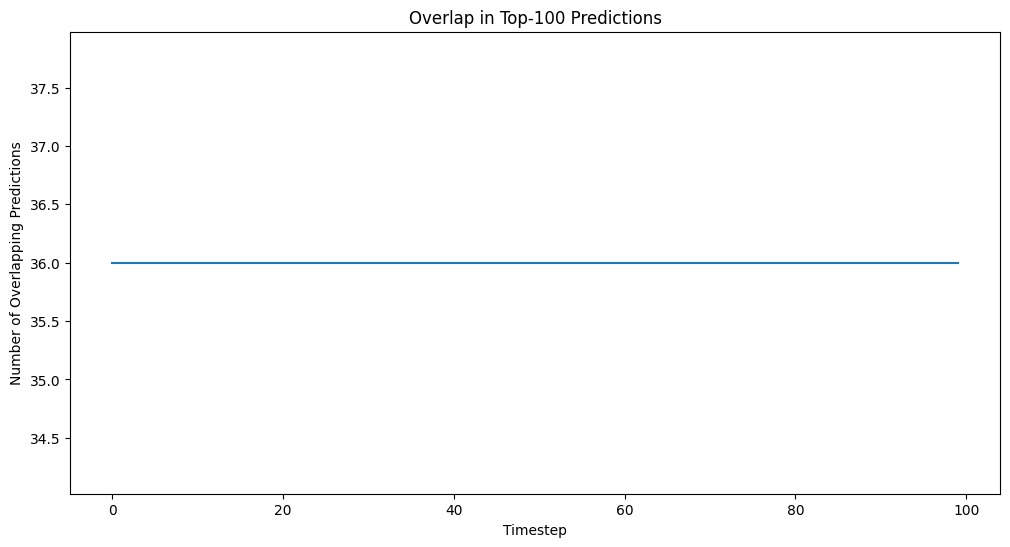

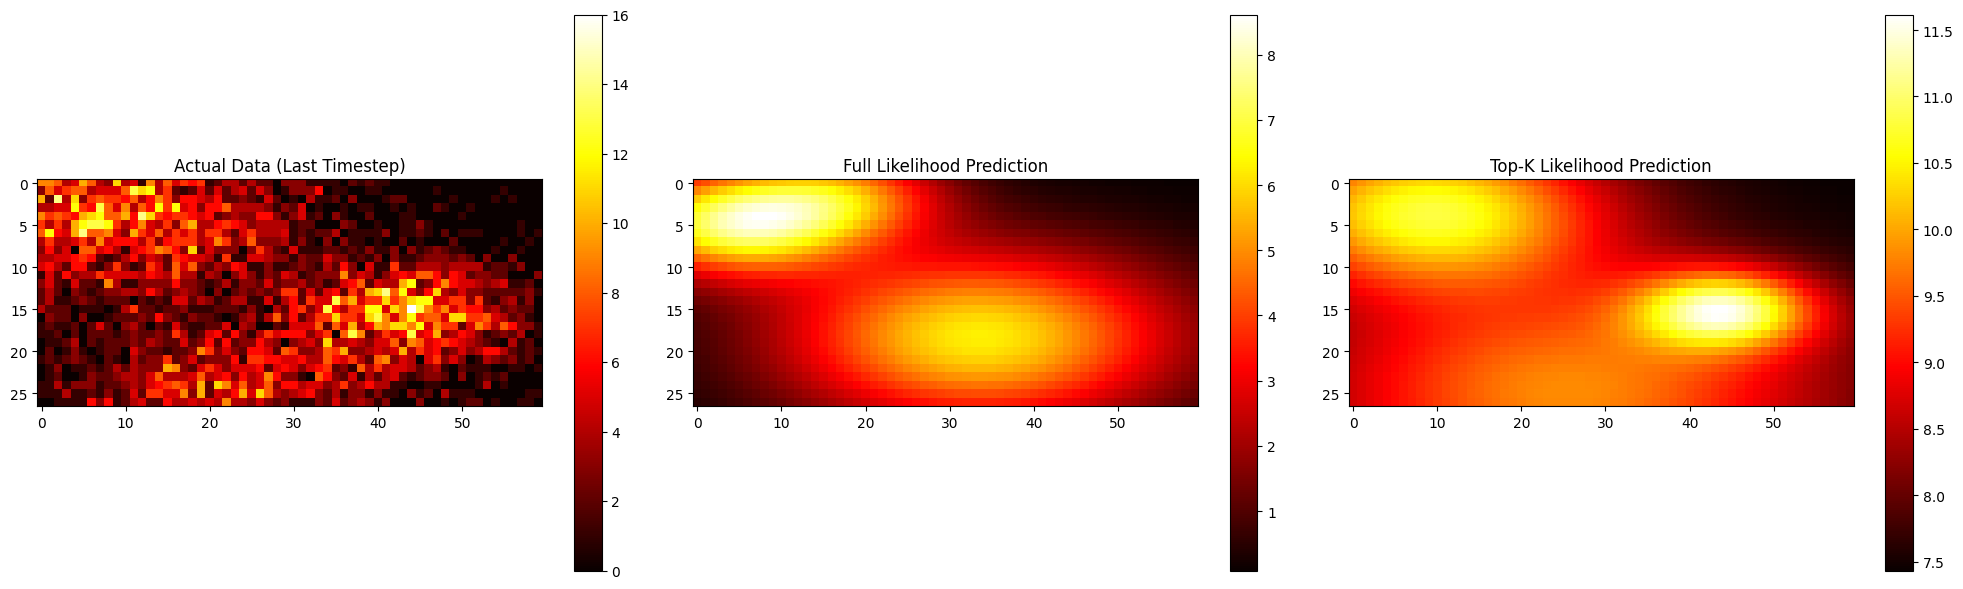

Data range:  0.0 22.0
Full likelihood MSE: 5.083637493793989
Top-K likelihood MSE: 39.50525792353496
Full likelihood Top-100 MSE: 31.028217568079025
Top-K likelihood Top-100 MSE: 2.236843719952351


In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from scipy.special import factorial, logsumexp

# Generate synthetic spatial-temporal dataset with hotspots
def generate_dataset(grid_shape=(27, 60), n_timesteps=100, n_hotspots=3):
    data = np.zeros((n_timesteps, grid_shape[0] * grid_shape[1]))
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    positions = np.dstack((x, y))

    # Create hotspots
    hotspots = np.random.rand(n_hotspots, 2)
    hotspot_intensities = np.random.uniform(5, 10, n_hotspots)
    hotspot_sizes = np.random.uniform(0.02, 0.05, n_hotspots)

    for t in range(n_timesteps):
        # Background rate
        background = np.random.poisson(0.1, size=grid_shape)
        
        # Add hotspots
        for i in range(n_hotspots):
            hotspot = multivariate_normal.pdf(positions, mean=hotspots[i], cov=hotspot_sizes[i])
            hotspot = hotspot / hotspot.max() * hotspot_intensities[i]
            background += np.random.poisson(hotspot)
        
        data[t] = background.flatten()
    
    return data

# Define model (mixture of background rate and hotspots)
def model_predict(params, grid_shape):
    background_rate = np.exp(params[0])
    n_hotspots = len(params[1:]) // 4
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    positions = np.dstack((x, y))
    
    prediction = np.full(grid_shape, background_rate)
    
    for i in range(n_hotspots):
        mu_x, mu_y, log_intensity, log_size = params[1+i*4:5+i*4]
        hotspot = multivariate_normal.pdf(positions, mean=[mu_x, mu_y], cov=np.exp(log_size))
        hotspot = hotspot / (hotspot.max() + 1e-10) * np.exp(log_intensity)
        prediction += hotspot
    
    return prediction.flatten()

# Log-likelihood function
def log_likelihood(params, data, grid_shape):
    prediction = model_predict(params, grid_shape)
    return np.sum(data * np.log(prediction + 1e-10) - prediction )#- np.log(factorial(data) + 1e-10))

# Top-K log-likelihood function
def top_k_log_likelihood(params, data, grid_shape, k):
    prediction = model_predict(params, grid_shape)
    top_k_indices = np.argsort(data)[-k:]
    return np.sum(data[top_k_indices] * np.log(prediction[top_k_indices] + 1e-10) - prediction[top_k_indices])#- np.log(factorial(data[top_k_indices]) + 1e-10))

# Optimization function for full likelihood
def optimize_likelihood(data, grid_shape, initial_guess):
    def neg_log_likelihood(params):
        return -np.mean([log_likelihood(params, data[t], grid_shape) for t in range(data.shape[0])])
    
    bounds = [(-10, 2)] + [(-1, 2), (-1, 2), (-5, 5), (-10, 0)] * (len(initial_guess) // 4)
    result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Optimization function for top-K likelihood
def optimize_top_k(data, grid_shape, initial_guess, k):
    def neg_top_k_log_likelihood(params):
        return -np.mean([top_k_log_likelihood(params, data[t], grid_shape, k) for t in range(data.shape[0])])
    
    bounds = [(-10, 2)] + [(-1, 2), (-1, 2), (-5, 5), (-10, 0)] * (len(initial_guess) // 4)
    result = minimize(neg_top_k_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Function to get top-k predictions
def get_top_k_predictions(params, data, grid_shape, k):
    predictions = []
    for t in range(data.shape[0]):
        prediction = model_predict(params, grid_shape)
        top_k = set(np.argsort(prediction)[-k:])
        predictions.append(top_k)
    return predictions

# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate data
    grid_shape = (27, 60)
    n_timesteps = 100
    n_hotspots = 3
    data = generate_dataset(grid_shape, n_timesteps, n_hotspots)

    # Initial guess for parameters (log_background_rate, mu_x1, mu_y1, log_intensity1, log_size1, mu_x2, mu_y2, ...)
    initial_guess = [-2.3] + [0.5, 0.5, 1.0, -3.0] * n_hotspots

    # Optimize for full likelihood and top-K likelihood
    full_params = optimize_likelihood(data, grid_shape, initial_guess)
    top_k_params = optimize_top_k(data, grid_shape, initial_guess, k=100)

    print("Full likelihood parameters:", full_params)
    print("Top-K likelihood parameters:", top_k_params)

    # Get top-k predictions for both models
    full_top_k = get_top_k_predictions(full_params, data, grid_shape, 100)
    topk_top_k = get_top_k_predictions(top_k_params, data, grid_shape, 100)

    # Calculate overlap
    overlaps = [len(full_set & topk_set) for full_set, topk_set in zip(full_top_k, topk_top_k)]

    # Plot overlap
    plt.figure(figsize=(12, 6))
    plt.plot(range(n_timesteps), overlaps)
    plt.title("Overlap in Top-100 Predictions")
    plt.xlabel("Timestep")
    plt.ylabel("Number of Overlapping Predictions")
    plt.show()

    # Visualize the last timestep predictions
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    im0 = ax1.imshow(data[-1].reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax1.set_title("Actual Data (Last Timestep)")
    plt.colorbar(im0, ax=ax1)

    im1 = ax2.imshow(model_predict(full_params, grid_shape).reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax2.set_title("Full Likelihood Prediction")
    plt.colorbar(im1, ax=ax2)

    im2 = ax3.imshow(model_predict(top_k_params, grid_shape).reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax3.set_title("Top-K Likelihood Prediction")
    plt.colorbar(im2, ax=ax3)

    plt.tight_layout()
    plt.show()

    # Print the range of values in the dataset
    print("Data range: ", np.min(data), np.max(data))

    # Calculate and print the mean squared error for both models
    full_mse = np.mean((data[-1] - model_predict(full_params, grid_shape))**2)
    topk_mse = np.mean((data[-1] - model_predict(top_k_params, grid_shape))**2)
    print(f"Full likelihood MSE: {full_mse}")
    print(f"Top-K likelihood MSE: {topk_mse}")

    # Calculate and print the mean squared error for the top 100 points
    top_100_indices = np.argsort(data[-1])[-100:]
    full_top_100_mse = np.mean((data[-1][top_100_indices] - model_predict(full_params, grid_shape)[top_100_indices])**2)
    topk_top_100_mse = np.mean((data[-1][top_100_indices] - model_predict(top_k_params, grid_shape)[top_100_indices])**2)
    print(f"Full likelihood Top-100 MSE: {full_top_100_mse}")
    print(f"Top-K likelihood Top-100 MSE: {topk_top_100_mse}")

In [101]:
data.shape

(100, 1620)

In [137]:
deterministic_bpr(torch.tensor([model_predict(top_k_params, grid_shape,) for _ in range(100)]), torch.tensor(data),100).mean()

tensor(0.6321, dtype=torch.float64)

In [138]:
deterministic_bpr(torch.tensor([model_predict(full_params, grid_shape,) for _ in range(100)]), torch.tensor(data),100).mean()

tensor(0.7782, dtype=torch.float64)

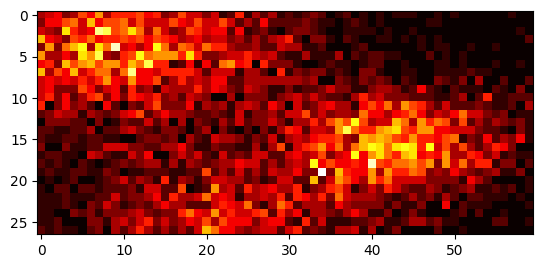

In [129]:
    plt.imshow(data[18].reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax1.set_title("Actual Data (Last Timestep)")
    plt.colorbar(im0, ax=ax1)

Full likelihood parameters: [-2.00798821  0.37846304  0.94355053  1.67582616 -2.48350927  0.15703218
  0.15183283  2.07857252 -2.33759934  0.73186347  0.59665305  2.21745682
 -3.19631893]
Top-K likelihood parameters: [2.         0.62546799 0.44570895 0.7277479  0.         0.62547009
 0.44571021 0.72774834 0.         0.62546996 0.44571032 0.72774838
 0.        ]


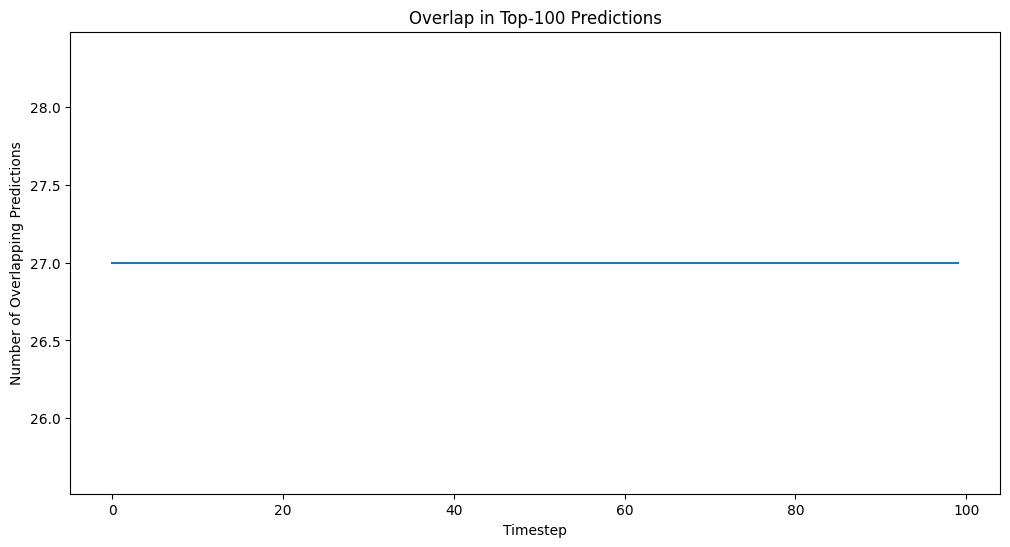

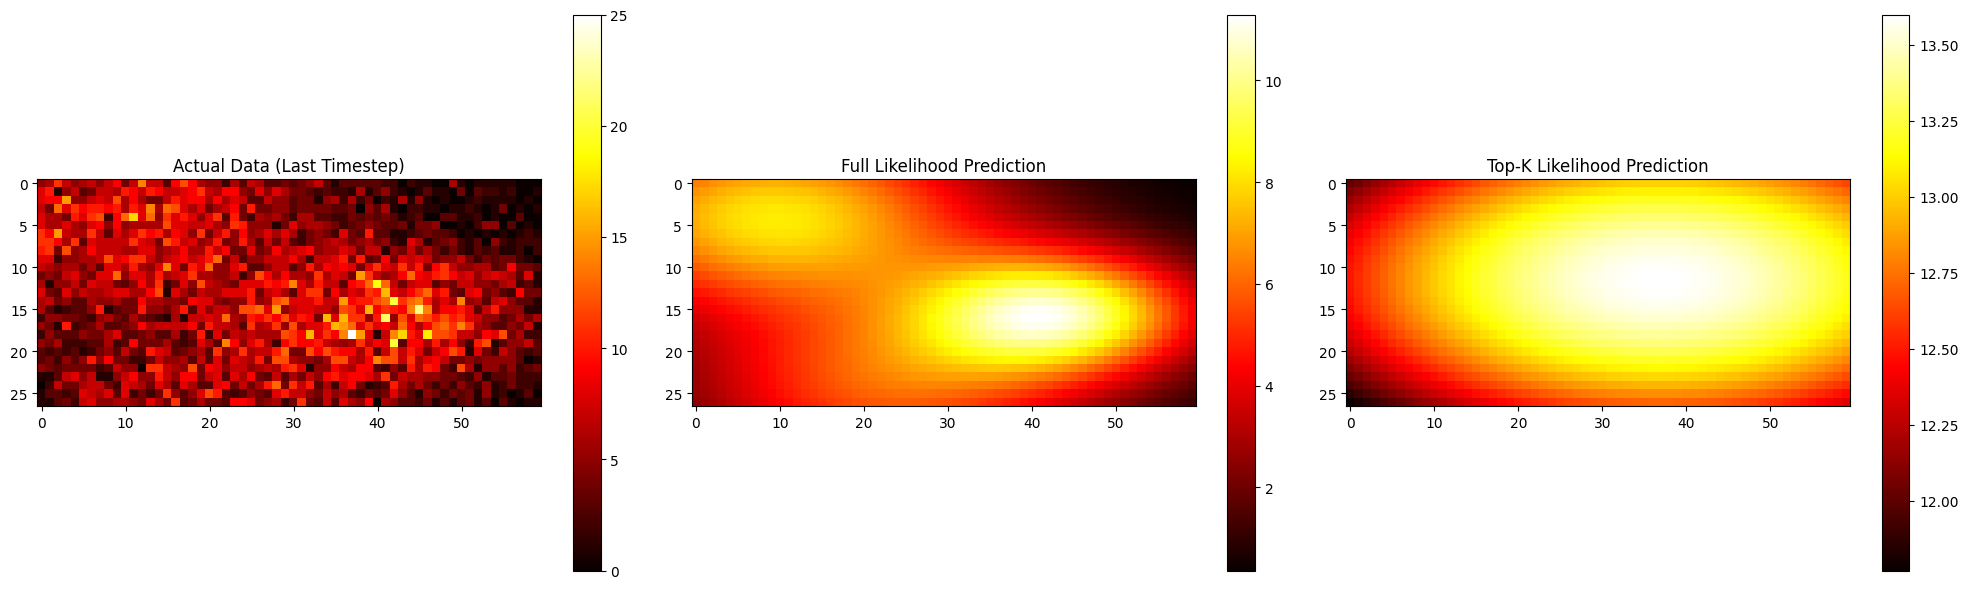

Data range:  0.0 25.0
Full likelihood MSE: 6.162939964723171
Top-K likelihood MSE: 62.49162256100336
Full likelihood Top-100 MSE: 29.465189399441574
Top-K likelihood Top-100 MSE: 5.772101406080873


In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from scipy.special import factorial

# Generate synthetic spatial-temporal dataset with hotspots and non-linear intensity
def generate_dataset(grid_shape=(27, 60), n_timesteps=100, n_hotspots=3):
    data = np.zeros((n_timesteps, grid_shape[0] * grid_shape[1]))
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    positions = np.dstack((x, y))

    # Create hotspots
    hotspots = np.random.rand(n_hotspots, 2)
    hotspot_intensities = np.random.uniform(5, 10, n_hotspots)
    hotspot_sizes = np.random.uniform(0.02, 0.05, n_hotspots)

    for t in range(n_timesteps):
        # Background rate
        background = np.random.poisson(0.1, size=grid_shape)
        
        # Add hotspots with non-linear intensity
        for i in range(n_hotspots):
            hotspot = multivariate_normal.pdf(positions, mean=hotspots[i], cov=hotspot_sizes[i])
            # Apply non-linear transformation to hotspot intensity
            hotspot = np.power(hotspot / hotspot.max(), 0.5) * hotspot_intensities[i]
            background += np.random.poisson(hotspot)
        
        data[t] = background.flatten()
    
    return data

# Define model (mixture of background rate and hotspots) - Note: this model doesn't account for the non-linearity
def model_predict(params, grid_shape):
    background_rate = np.exp(params[0])
    n_hotspots = len(params[1:]) // 4
    x, y = np.meshgrid(np.linspace(0, 1, grid_shape[1]), np.linspace(0, 1, grid_shape[0]))
    positions = np.dstack((x, y))
    
    prediction = np.full(grid_shape, background_rate)
    
    for i in range(n_hotspots):
        mu_x, mu_y, log_intensity, log_size = params[1+i*4:5+i*4]
        hotspot = multivariate_normal.pdf(positions, mean=[mu_x, mu_y], cov=np.exp(log_size))
        hotspot = hotspot / (hotspot.max() + 1e-10) * np.exp(log_intensity)
        prediction += hotspot
    
    return prediction.flatten()

# Log-likelihood function
def log_likelihood(params, data, grid_shape):
    prediction = model_predict(params, grid_shape)
    return np.sum(data * np.log(prediction + 1e-10) - prediction - np.log(factorial(data) + 1e-10))

# Top-K log-likelihood function
def top_k_log_likelihood(params, data, grid_shape, k):
    prediction = model_predict(params, grid_shape)
    top_k_indices = np.argsort(data)[-k:]
    return np.sum(data[top_k_indices] * np.log(prediction[top_k_indices] + 1e-10) - prediction[top_k_indices] - np.log(factorial(data[top_k_indices]) + 1e-10))

# Optimization function for full likelihood
def optimize_likelihood(data, grid_shape, initial_guess):
    def neg_log_likelihood(params):
        return -np.mean([log_likelihood(params, data[t], grid_shape) for t in range(data.shape[0])])
    
    bounds = [(-10, 2)] + [(-1, 2), (-1, 2), (-5, 5), (-10, 0)] * (len(initial_guess) // 4)
    result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Optimization function for top-K likelihood
def optimize_top_k(data, grid_shape, initial_guess, k):
    def neg_top_k_log_likelihood(params):
        return -np.mean([top_k_log_likelihood(params, data[t], grid_shape, k) for t in range(data.shape[0])])
    
    bounds = [(-10, 2)] + [(-1, 2), (-1, 2), (-5, 5), (-10, 0)] * (len(initial_guess) // 4)
    result = minimize(neg_top_k_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
    return result.x

# Function to get top-k predictions
def get_top_k_predictions(params, data, grid_shape, k):
    predictions = []
    for t in range(data.shape[0]):
        prediction = model_predict(params, grid_shape)
        top_k = set(np.argsort(prediction)[-k:])
        predictions.append(top_k)
    return predictions

# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate data
    grid_shape = (27, 60)
    n_timesteps = 100
    n_hotspots = 3
    data = generate_dataset(grid_shape, n_timesteps, n_hotspots)

    # Initial guess for parameters (log_background_rate, mu_x1, mu_y1, log_intensity1, log_size1, mu_x2, mu_y2, ...)
    initial_guess = [-2.3] + [0.5, 0.5, 1.0, -3.0] * n_hotspots

    # Optimize for full likelihood and top-K likelihood
    full_params = optimize_likelihood(data, grid_shape, initial_guess)
    top_k_params = optimize_top_k(data, grid_shape, initial_guess, k=100)

    print("Full likelihood parameters:", full_params)
    print("Top-K likelihood parameters:", top_k_params)

    # Get top-k predictions for both models
    full_top_k = get_top_k_predictions(full_params, data, grid_shape, 100)
    topk_top_k = get_top_k_predictions(top_k_params, data, grid_shape, 100)

    # Calculate overlap
    overlaps = [len(full_set & topk_set) for full_set, topk_set in zip(full_top_k, topk_top_k)]

    # Plot overlap
    plt.figure(figsize=(12, 6))
    plt.plot(range(n_timesteps), overlaps)
    plt.title("Overlap in Top-100 Predictions")
    plt.xlabel("Timestep")
    plt.ylabel("Number of Overlapping Predictions")
    plt.show()

    # Visualize the last timestep predictions
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    im0 = ax1.imshow(data[-1].reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax1.set_title("Actual Data (Last Timestep)")
    plt.colorbar(im0, ax=ax1)

    im1 = ax2.imshow(model_predict(full_params, grid_shape).reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax2.set_title("Full Likelihood Prediction")
    plt.colorbar(im1, ax=ax2)

    im2 = ax3.imshow(model_predict(top_k_params, grid_shape).reshape(grid_shape), cmap='hot', interpolation='nearest')
    ax3.set_title("Top-K Likelihood Prediction")
    plt.colorbar(im2, ax=ax3)

    plt.tight_layout()
    plt.show()

    # Print the range of values in the dataset
    print("Data range: ", np.min(data), np.max(data))

    # Calculate and print the mean squared error for both models
    full_mse = np.mean((data[-1] - model_predict(full_params, grid_shape))**2)
    topk_mse = np.mean((data[-1] - model_predict(top_k_params, grid_shape))**2)
    print(f"Full likelihood MSE: {full_mse}")
    print(f"Top-K likelihood MSE: {topk_mse}")

    # Calculate and print the mean squared error for the top 100 points
    top_100_indices = np.argsort(data[-1])[-100:]
    full_top_100_mse = np.mean((data[-1][top_100_indices] - model_predict(full_params, grid_shape)[top_100_indices])**2)
    topk_top_100_mse = np.mean((data[-1][top_100_indices] - model_predict(top_k_params, grid_shape)[top_100_indices])**2)
    print(f"Full likelihood Top-100 MSE: {full_top_100_mse}")
    print(f"Top-K likelihood Top-100 MSE: {topk_top_100_mse}")